# Image Segmentation

The main objectives of this module are:

* Use & compare different methods of segmentation:
    * Histogram-based
    * Texture-based
    * Region growing
* Detect objects and extract object features.
* Understand corner detection and basic object recognition

## 1. Histogram segmentation

In histogram segmentation, we make the hypothesis that the histogram is composed of distinct separable distributions, and we try to find the best threshold to separate those distributions.

The code below uses a default threshold of 127 to segment the image. Modify it to:

1. Create a function to compute the optimal threshold for an 8 bit image. Apply on the cameraman image.
1. Compute the Otsu threshold for an 8-bit image, by optimizing within variance or inter-class variance for each possible theshold *t*. See [here](http://nbviewer.jupyter.org/github/odebeir/info-h-500-501/blob/ver_2016-2017/04-Image%20segmentation/01-Histogram%20based%20image%20segmentation.ipynb) how to compute the Otsu threshold.

In [213]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imshow

def manual_threshold(im, T):
    return im>T

def compute_histogram(im) :
    h = np.zeros(256)
    for pixel in im.flatten() :
        h[pixel] += 1
    return h/h.sum()

def optimal_threshold(im, T0):
    
    ## Histogram-based segmentation : initial treshold T0 for the histogram
    # First, compute histogram
    norm_hist = compute_histogram(im)
    # Then, divide the histogram into two zones
    g1 = norm_hist[:T0]
    g2 = norm_hist[T0:]
    
    # Compute centroids
    m1 = (np.arange(0, g1.size)*g1).sum()/g1.sum()
    m2 = (np.arange(T0, len(norm_hist))*g2).sum()/g2.sum()
    
    t_iter = int((m1+m2)//2)
    print(m1, m2, t_iter)
    if t_iter == T0 :
        return t_iter
    else :
        return optimal_threshold(im, t_iter)
    
def omega(hist, k) :
    return hist[:k].sum()
def mu(hist, k) :
    return (np.arange(0, k)*hist[:k]).sum()
    
def otsu_threshold(im):
    norm_hist = compute_histogram(im)
    max_sep = -9999
    threshold = 0
    for k in range(len(norm_hist)) :
        # Probabilities of the classes
        w_0 = norm_hist[:k].sum()
        w_1 = norm_hist[k:].sum()

        # Means 
        mu_0 = (np.arange(0,k)*w_0).sum()/w_0
        mu_1 = (np.arange(k,len(norm_hist))*w_1).sum()/w_1

        # Variances
        sigma_0 = ((np.arange(0, k)-mu_0)**2 *norm_hist[:k]/w_0).sum()
        sigma_1 = ((np.arange(k, len(norm_hist))-mu_1)**2 *norm_hist[k:]/w_1).sum()

        inter_class_variance = w_0*w_1*(mu_1-mu_0)**2
        intra_class_variance = w_0*sigma_0 + w_1*sigma_1

        # Separability
        sep = inter_class_variance/intra_class_variance
        if sep > max_sep :
            threshold = k
            max_sep = sep
            
    return threshold
    
    

In [214]:
def plot_histogram_with_threshold(im, T):
    plt.figure(figsize=(25,5))
    h = plt.hist(im.flatten(), bins=range(256))
    plt.plot([T,T],[0,h[0].max()], 'r-')
    plt.show()

76.59221224975607 169.58800527054024 123
49.43790119730355 160.39001191982993 104
30.720814949390086 154.7967571481057 92
24.327357954545455 152.83452415720961 88
23.158285135916714 152.42777639597065 87
22.904349214644483 152.3350132982852 87


/home/sami/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


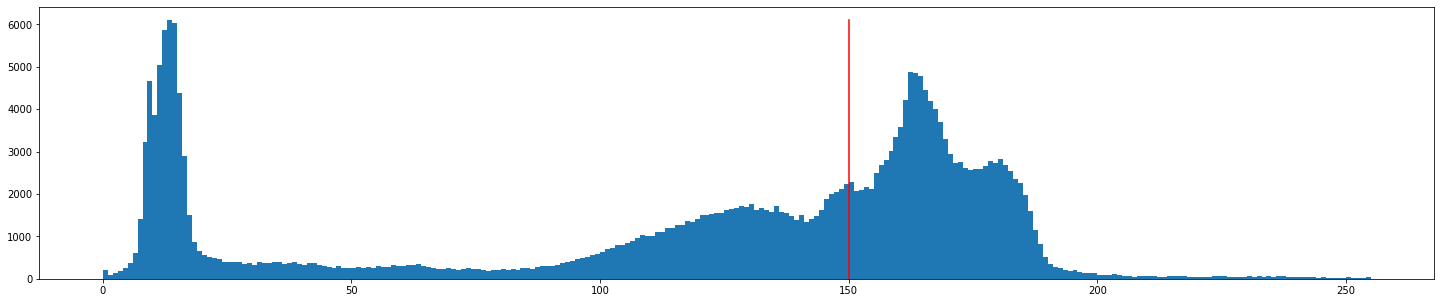

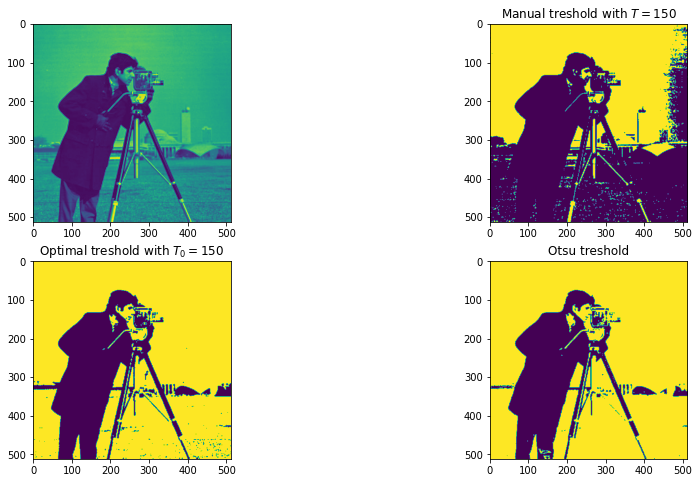

In [215]:
im = imread('camera.jpg')

T = 150
treshold = optimal_threshold(im, T)
otsu = otsu_threshold(im)
im_segmented_1 = manual_threshold(im, T)
im_segmented_2 = im > treshold
im_segmented_3 = im > otsu

plot_histogram_with_threshold(im, T)

# Show original image & segmented binary image
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.imshow(im)
plt.subplot(2,2,2)
plt.title("Manual treshold with $T = $"+ str(T))
plt.imshow(im_segmented_1)
plt.subplot(2,2,3)
plt.title("Optimal treshold with $T_0 = $" + str(T))
plt.imshow(im_segmented_2)


plt.subplot(2,2,4)
plt.title("Otsu treshold")
plt.imshow(im_segmented_3)
plt.show()

# Conclusion
- Optimal treshold : we found a very stable point with this photo !

**Need more help? You can check the following videos:**

* [Manual thresholding](https://www.youtube.com/watch?v=rgKkws_fqz4&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=24)
* [Optimal threshold](https://www.youtube.com/watch?v=7B1cs0PARtg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=25)
* [Otsu threshold](https://www.youtube.com/watch?v=mz26bssSLds&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=26)

## 2. Texture segmentation

Texture segmentation uses regional descriptors to segment the image based on the local texture. A simple algorithm is provided below, which:

* Extract neighborhoods with the sliding window method
* Compute the local maximum on the neighborhood and put it in a "descriptor" image
* Use Otsu thresholding on the descriptor image to segment it
* Display the results

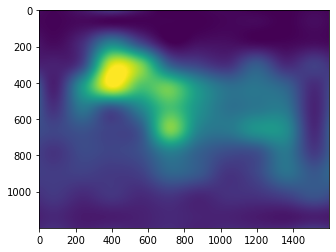

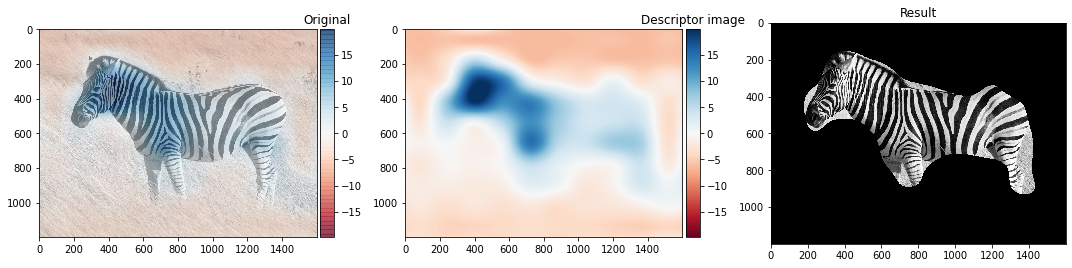

In [246]:
from skimage.feature import greycomatrix,greycoprops
from skimage.transform import resize
from skimage.filters.rank import entropy
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
angles = [0,np.pi/6,np.pi/3,np.pi/2,2*np.pi/3,5*np.pi/6]
displacements = [10]
props = ['dissimilarity']
def texture_descriptor(N):
    global angles, displacements, props
    
    gscm = greycomatrix(N, displacements, angles=angles, levels=256) 
    
    descriptors = []
    for prop in props :
        descriptors += [greycoprops(gscm, prop)]
    # If multiple properties, they will all be one after the other
    return np.array(descriptors).flatten()

def sliding_window(im, PATCH_SIZE):
    n_cells_x = im.shape[0]//PATCH_SIZE[0]
    n_cells_y = im.shape[1]//PATCH_SIZE[1]
    descriptors = np.zeros((n_cells_y,n_cells_x,len(angles)*len(displacements)*len(props)))

    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(n_cells_x) :
        for j in range(n_cells_y) :
            patch = im[i*PATCH_SIZE[0]: (i+1)*PATCH_SIZE[0], j*PATCH_SIZE[1]: (j+1)*PATCH_SIZE[1]]
            descr = texture_descriptor(patch)
            # Instead of computing a constant value and assigning it to a whole region of an array,
            # Here filling the constant value at one index in an array
            # Then, resizing the whole array after normalization
            descriptors[i,j] = descr
    
    ndescriptors = (descriptors-descriptors.mean(axis=(0,1)))/descriptors.std(axis=(0,1))
    output = resize(descriptors, im.shape)
    
    # Sum for all the properties (on axis=2)
    overlay = resize(ndescriptors.sum(axis=2), im.shape[:2], order=3)

    # At the end, we resize the output
    plt.imshow(overlay)
    return overlay


# Open zebra image as an 8-bit integer grayscale
im = img_as_ubyte(imread("zebra.jpg", as_gray=True))

im_descr = sliding_window(im,(120,160))
T = threshold_otsu(im_descr)
mask = im_descr>T

plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
imshow(im)
imshow(im_descr, alpha=0.5)
plt.title('Original')
plt.subplot(1,3,2)
imshow(im_descr)
plt.title('Descriptor image')
plt.subplot(1,3,3)
imshow(im*mask)
plt.title('Result')
plt.show()

Using the above example as a starting point, replace the "maximum" texture descriptor by properties from the co-occurrence matrix:
* Compute the co-occurrence matrix on the neighborhood (see [greycomatrix](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycomatrix)). Test different angles & displacements.
* Test different properties (see [greycoprops](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycoprops))

Try to segment the zebra image as best as you can using those descriptors.

**Need more help? You can check the following videos:**

* [Region descriptors](https://www.youtube.com/watch?v=5F9aPiab8PA&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=27)
* [Properties of the co-occurrence matrix](https://www.youtube.com/watch?v=NR3vrkZ9tyg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=28)
* [Texture segmentation](https://www.youtube.com/watch?v=b-SGhLu-R0c&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=29)

## 3. Region growing

In region growing algorithms, we start from "markers" which act as seed points, and grow the segmented regions from those markers. A well-known region-growing algorithm uses the watershed transform. The example below uses the watershed transform on the cameraman image, with hand-picked markers:

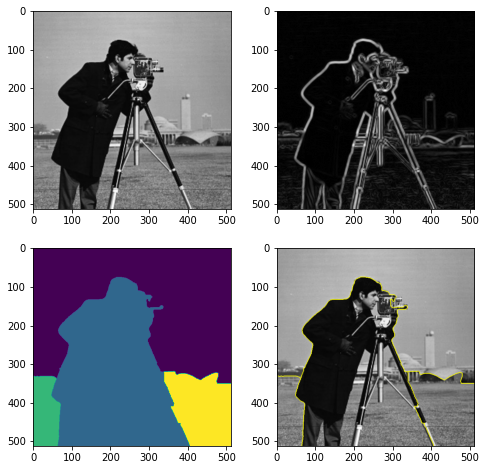

In [217]:
from skimage.morphology import disk
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries, watershed
from skimage.io import imread

im = imread('camera.jpg')

smoothing_factor = 4
# Compute the gradients of the image:
gradient = skr.gradient(skr.mean(im, disk(smoothing_factor)), disk(1))

# Hand-picked markers for the road image
markers_coordinates = [
    [10,256], # sky
    [200,150],# cameraman
    [400,20], # grass (left)
    [400,450] # grass (right)
]

markers = np.zeros_like(im)
for i,(row,col) in enumerate(markers_coordinates):
    markers[row,col] = i+1

ws = watershed(gradient, markers)

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(im,cmap=plt.cm.gray);
plt.subplot(2,2,2)
plt.imshow(gradient,cmap=plt.cm.gray);
plt.subplot(2,2,3)
plt.imshow(ws);
plt.subplot(2,2,4)
plt.imshow(mark_boundaries(im,ws));

Adapt this method to work on the road image.

Can you find a way to automatically determine the markers?

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.morphology import disk
import skimage.filters.rank as skr
from skimage.filters import gaussian, sobel
from skimage.segmentation import mark_boundaries, watershed
from skimage.io import imread, imshow

In [219]:
%matplotlib inline

/home/sami/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


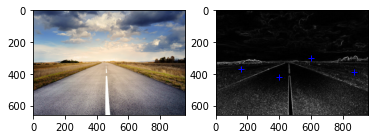

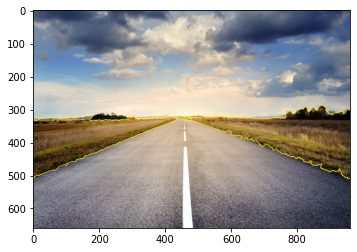

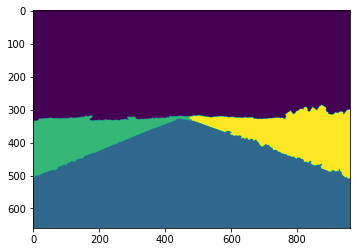

In [220]:
im = imread('road.jpg')

# Pre-processing image

# Method 1 : median filter for noice reduction
smoothing_factor = 15
im_r = skr.median(im[:,:,0], disk(smoothing_factor))
im_g = skr.median(im[:,:,1], disk(smoothing_factor))
im_b = skr.median(im[:,:,2], disk(smoothing_factor))

gradient_r = skr.gradient(im_r, disk(1))
gradient_g = skr.gradient(im_g, disk(1))
gradient_b = skr.gradient(im_b, disk(1))


grad = gradient_r+gradient_g+gradient_b

# Method 2 : gaussian to blur the image
# im_ = gaussian(im, sigma=4)

# gradient_r = skr.gradient(im_[:,:,0], disk(1))
# gradient_g = skr.gradient(im_[:,:,1], disk(1))
# gradient_b = skr.gradient(im_[:,:,2], disk(1))
# grad = gradient_r+gradient_g+gradient_b

# Method 3 : sobel filter, turned out to be the best one !
im_ = sobel(im)
gradient_r = skr.gradient(im_[:,:,0], disk(1))
gradient_g = skr.gradient(im_[:,:,1], disk(1))
gradient_b = skr.gradient(im_[:,:,2], disk(1))
grad = gradient_r+gradient_g+gradient_b

markers_coordinates = np.array([
    [300, 600], # sky
    [420, 400], # road
    [368, 160], # left grass
    [390, 869]  # right grass
])

# Now we need an image where only these markers are set to 1, the other are set to zero
markers = np.zeros_like(im[:,:,0])
for i,(row,col) in enumerate(markers_coordinates):
    markers[row,col] = i+1

ws = watershed(grad, markers)


plt.figure()
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(grad, cmap=cm.gray)
plt.plot(markers_coordinates[:,1],markers_coordinates[:,0],'b+')
plt.show()

plt.figure()
plt.imshow(mark_boundaries(im,ws))
plt.figure()
plt.imshow(ws)
plt.show()

Another use of the watershed transform is to separate overlapping object, as in the image below.

* Compute the [distance transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html#scipy.ndimage.distance_transform_edt) of the image.
* Use the result to automatically find good markers.
* Use the watershed transform to separate the three objects.

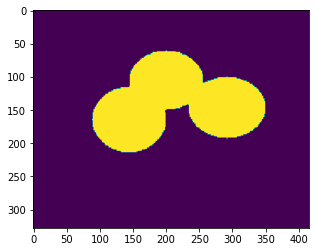

In [221]:
from scipy.ndimage import distance_transform_edt
from skimage.color import rgb2gray

im = rgb2gray(imread('separ.png'))==0
plt.figure()
plt.imshow(im)
plt.show()
# Your code here


**Need more help? You can check the following videos:**

* [Markers for region growing](https://www.youtube.com/watch?v=3e0-rE9zhFk&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=30)
* [Watershed transform](https://www.youtube.com/watch?v=GuVp7dlzEKE&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=31)
* [Distance transform](https://www.youtube.com/watch?v=s1eABOdNnVg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=32)

## 4. Object features

The next step after segmentation is often to extract object features in order to recognize, classify, or measure information about the objects.

Starting from the example below:

1. **Extract connected components** (see [label()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=label#skimage.measure.label)) of the shapes image and **display the centroid of the objects** (see [regionprops()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops))
1. For each image label, **extract the coordinates of the contour** (see [find_contours()](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.find_contours)) and **find the corners** of each objects.
1. Suggest a method to **classify the objects** in different categories.

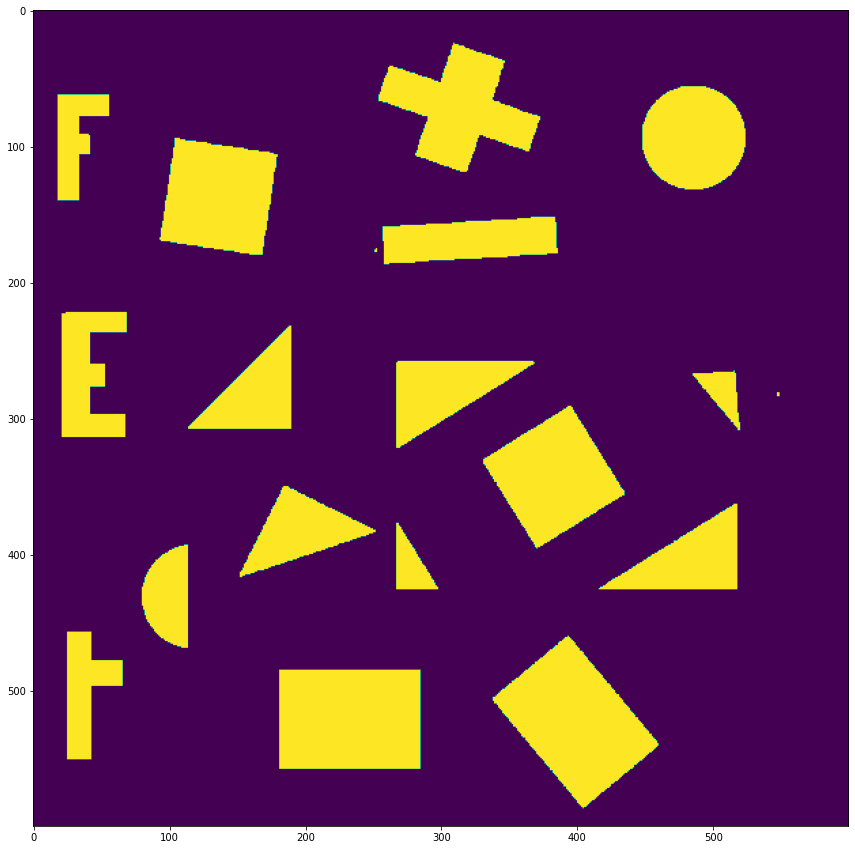

In [222]:
from skimage.measure import label, regionprops,find_contours

im = (imread('shapes.png')[:,:,0]>0).astype(int) #binarize & cast to integer to make it easier to process later

plt.figure(figsize=(15,15))
plt.imshow(im)
plt.show()

In [223]:

# Your code here


**Need more help? You can check the following videos:**

* [Object labeling & features](https://www.youtube.com/watch?v=7bOH4E7c8gU&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=33)

# Coding project - Tumour segmentation

The image below is a slice of a brain MRI with a large tumour in it. The goal of this project is to create an algorithm to automatically segment the tumour.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumour (in cm²). 

In [330]:
from skimage.io import imread,imshow
import matplotlib.pyplot as plt
%matplotlib inline

im = imread('mri_brain.jpg')


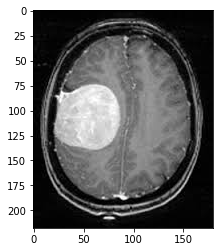

In [331]:
plt.figure()
plt.imshow(im)
plt.show()

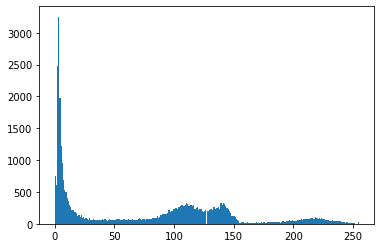

In [332]:
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
from skimage.color import rgb2hed, rgb2hsv, rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import opening,closing,disk
from skimage.segmentation import mark_boundaries

im = imread('mri_brain.jpg')
gray = rgb2gray(im)*255
plt.figure()
plt.hist(gray.flatten(), bins=257)
plt.show()

## Observation of the histogram
We can see from the histogram that computing an Otsu threshold wouldn't be the best idea because the region that interests us is very unrepresented.

## Watershed method
- Need to get the markers
- If needed, get through a median filter first for noise reduction

In [333]:
# Noise reduction : median filter

In [334]:
smoothing_factor = 15
im_r = skr.median(im[:,:,0], disk(smoothing_factor))
im_g = skr.median(im[:,:,1], disk(smoothing_factor))
im_b = skr.median(im[:,:,2], disk(smoothing_factor))

gradient_r = skr.gradient(im_r, disk(1))
gradient_g = skr.gradient(im_g, disk(1))
gradient_b = skr.gradient(im_b, disk(1))


grad = gradient_r+gradient_g+gradient_b

/home/sami/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  after removing the cwd from sys.path.
/home/sami/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  if sys.path[0] == '':
/home/sami/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  after removing the cwd from sys.path.
/home/sami/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Possible precision loss converting image of type float64 to uint8 as requir

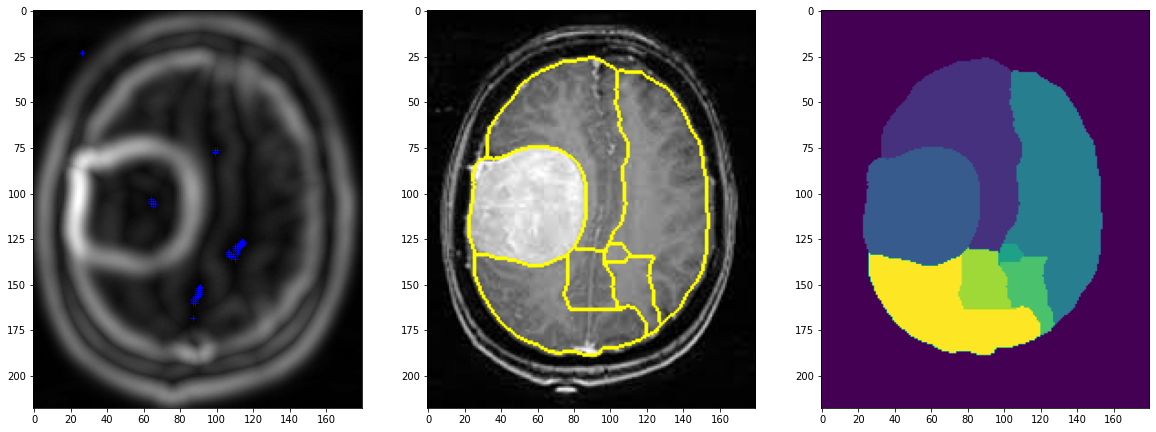

In [335]:
from skimage.feature import peak_local_max

def get_markers(im, indices=False):
    im_ = gaussian(im, sigma=4)
    gradr = skr.gradient(im_[:,:,0],disk(5)).astype('int')
    gradg = skr.gradient(im_[:,:,1],disk(5)).astype('int')
    gradb = skr.gradient(im_[:,:,2],disk(5)).astype('int')
    grad = gradr+gradg+gradb
    
    return peak_local_max(grad.max()-grad,threshold_rel=0.5, min_distance=22,indices=indices),grad

markers,grad = get_markers(im, True)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(grad, cmap=plt.cm.gray)
plt.plot(markers[:,1],markers[:,0],'b+')
plt.subplot(1,3,2)


## Need to compute Markers with "indices" set to False
from skimage.measure import label
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
markers,grad = get_markers(im, False)
markers = label(markers)
ws = watershed(grad, markers)

plt.imshow(mark_boundaries(im,ws))
plt.subplot(1,3,3)
plt.imshow(ws)
plt.show()

# Advanced feature : watershed art on the face of Sir Isaac Newton

Goal : isolate his head, and compute a watershed transform on his head to get a beautiful digital art work (such as in https://displate.com/displate/1263338)

### Pre-processing : distance transform to compute a mask to isolate Sir Isaac Newton's head
Multiple options :
- Otsu threshold on Value (RGB -> HSV) to compute a mask : 
    - Automatic
    - Turned out to be fast and easy
- Distance transform to compute a mask: 
    - Need to choose a reference coordinate, as the background is not a unique color
    - The reference coordinate is very important and hard to choose
- Greycoprops
    - No particular pattern in the image, so not good


#### Otsu threshold on Value

In [337]:
from skimage.io import imread,imshow
from skimage.color import rgb2hsv

import matplotlib.pyplot as plt
%matplotlib inline

im = img_as_ubyte(imread('newton.jpg'))
hsv = rgb2hsv(im)
h = hsv[:,:,0]*255
s = hsv[:,:,1]*255
v = hsv[:,:,2]*255
im_r = im[:,:,0]
im_g = im[:,:,1]
im_b = im[:,:,2]

In [305]:
%%cache
plt.figure(figsize=(20,8))
plt.subplot(1,4,1)
plt.imshow(im)
plt.subplot(1,4,2)
plt.imshow(h)
plt.subplot(1,4,3)
plt.imshow(s)
plt.subplot(1,4,4)
plt.imshow(v)
plt.show()

# We see that a otsu threshold on the V is a good idea

UsageError: Cell magic `%%cache` not found.


In [306]:
%%cache
# RGB histograms
def norm_hist(ima):
    hist,bins = np.histogram(ima.flatten(),range(256))  # histogram is computed on a 1D distribution --> flatten()
    return 1.*hist/np.sum(hist) # normalized histogram
nh_r = norm_hist(im_r)
nh_g = norm_hist(im_g)
nh_b = norm_hist(im_b)
nh_h = norm_hist(v)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title("RGB histograms")
plt.plot(nh_r, color='r', label="Red")
plt.plot(nh_g, color='g', label="Green")
plt.plot(nh_b, color='b', label="Blue")

plt.subplot(1,2,2)
plt.title("Value histogram")
plt.plot(nh_v)
plt.show()

UsageError: Cell magic `%%cache` not found.


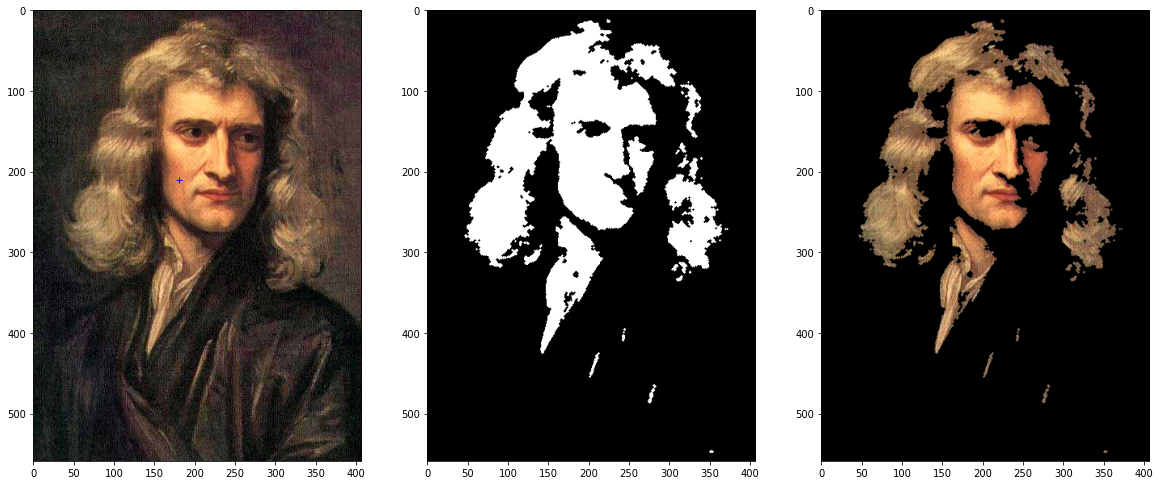

In [338]:
t = threshold_otsu(v)
mask = v > t

struct_el = disk(1) # put the radius to 0 if no effect wanted
mask = closing(opening(mask, struct_el),struct_el)


im_m = im.copy()
im_m[mask==False] = 0

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(180,210,'b+')
plt.imshow(im, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.imshow(mask, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(im_m, cmap=plt.cm.gray)
plt.show()

#### Otsu threshold on distance map (attention, this replaces the previously computed mask!)

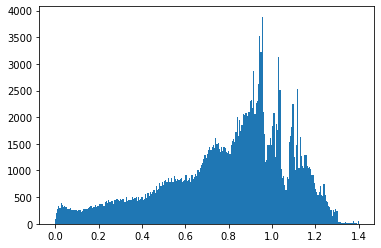

In [233]:
from skimage.filters import threshold_otsu

def distance_color_space(im, coords):
    refcolor = im[coords[0],coords[1]]
    dmap = np.sqrt(((im-refcolor)**2).sum(axis=2))
    return dmap

coords = (177, 188)

dmap = distance_color_space(hsv.astype('float'), coords)
h,bins = np.histogram(dmap.flatten(),bins=256)

plt.figure()
plt.bar(bins[:-1],h,bins[1]-bins[0])
plt.show()



In [234]:
otsu_t = threshold_otsu(dmap)

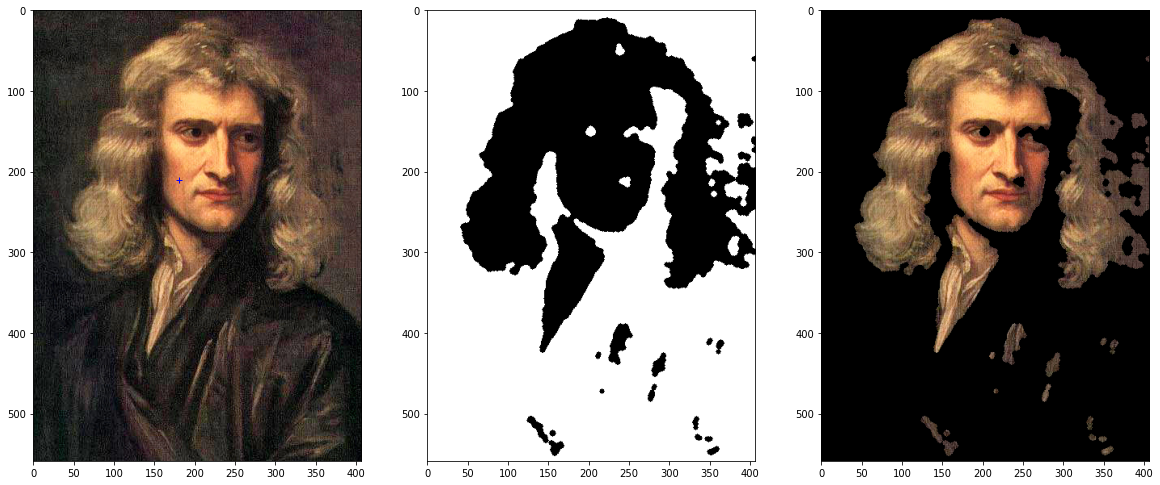

In [235]:
from skimage.morphology import opening,closing,disk

mask = dmap>otsu_t
struct_el = disk(3) # put the radius to 0 if no effect wanted
mask = closing(opening(mask, struct_el),struct_el)

im_m = im.copy()
im_m[mask==True] = 0

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(180,210,'b+')
plt.imshow(im, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.imshow(mask, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(im_m, cmap=plt.cm.gray)
plt.show()

## Now we can dig into the ostu-thresholded-face of Sir Isaac Newton
And we can watershed-transform it

In [339]:
# First, compute the gradients
im_r = im_m[:,:,0]
im_g = im_m[:,:,1]
im_b = im_m[:,:,2]

gradient_r = skr.gradient(im_r, disk(4))
gradient_g = skr.gradient(im_g, disk(4))
gradient_b = skr.gradient(im_b, disk(4))


grad = gradient_r+gradient_g+gradient_b

/home/sami/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sami/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  # This is added back by InteractiveShellApp.init_path()
/home/sami/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sami/.local/lib/python3.6/site-packa

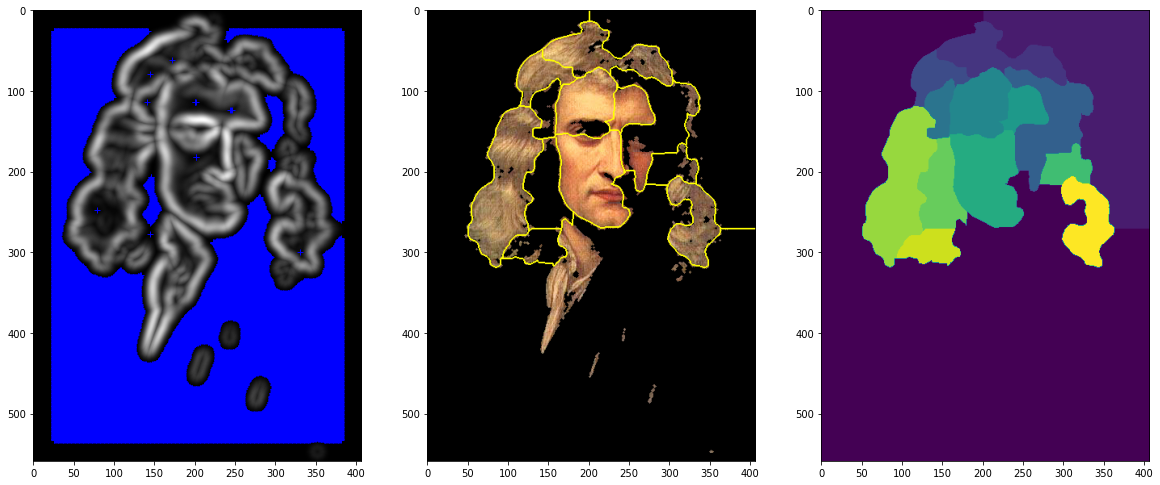

In [373]:
# Only difference for between this one and the last one : min_distance
def get_markers(im, indices=False):
    im_ = gaussian(im, sigma=4)
    gradr = skr.gradient(im_[:,:,0],disk(5)).astype('int')
    gradg = skr.gradient(im_[:,:,1],disk(5)).astype('int')
    gradb = skr.gradient(im_[:,:,2],disk(5)).astype('int')
    grad = gradr+gradg+gradb
    
    return peak_local_max(grad.max()-grad,threshold_rel=0.5, min_distance=25,indices=indices),grad

markers,grad = get_markers(im_m, True)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(grad, cmap=plt.cm.gray)
plt.plot(markers[:,1],markers[:,0],'b+')
plt.subplot(1,3,2)

## Need to compute Markers with "indices" set to False
from skimage.measure import label
from skimage.morphology import watershed
from skimage.segmentation import mark_boundaries
markers,grad = get_markers(im_m, False)
markers = label(markers)
ws = watershed(grad, markers)

plt.imshow(mark_boundaries(im_m,ws))
plt.subplot(1,3,3)
plt.imshow(ws)
plt.show()

####  Results
Okay i'm not the best artist but at least it was interesting to do